In [188]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, lasso_path
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency





In [189]:
data = pd.read_csv('BigCitiesHealth.csv')

In [190]:
data.shape

(148292, 31)

In [191]:
data.describe()

,geo_fips_code,value,date_label,value_95_ci_low,value_95_ci_high,value_90_ci_low,value_90_ci_high
count,1.471950e+05,147522.000000,148292.000000,93378.000000,93388.000000,0.0,0.0
mean,2.880322e+06,830.377923,2015.227996,468.838106,568.740516,NaN,NaN
std,1.697827e+06,4304.120276,3.112534,1742.895189,2043.575501,NaN,NaN
min,4.550000e+05,-1.052184,2010.000000,-148.037039,0.458320,NaN,NaN
25%,8.200000e+05,10.851578,2013.000000,9.337966,15.449973,NaN,NaN
50%,2.938000e+06,26.743773,2015.000000,23.259248,34.061614,NaN,NaN
75%,4.748000e+06,77.161225,2018.000000,109.929802,149.434371,NaN,NaN
max,5.553000e+06,99408.000000,2020.000000,22650.600880,29193.761110,NaN,NaN


In [192]:
data.dtypes

metric_item_label                   object
metric_cat_label                    object
metric_subcat_label                 object
metric_item_label_subtitle          object
metric_cat_item_yaxis_label         object
metric_source_desc_label_fn         object
metric_source_desc_label_url_fn     object
geo_label_city                      object
geo_label_state                     object
geo_label_citystate                 object
geo_fips_code                      float64
value                              float64
date_label                           int64
geo_label_proxy_or_real             object
geo_label_proxy_footnote            object
geo_fips_desc                       object
date_label_proxy_or_real            object
date_label_proxy_footnote           object
value_ci_flag_yesno                 object
value_95_ci_low                    float64
value_95_ci_high                   float64
value_90_ci_low                    float64
value_90_ci_high                   float64
geo_strata_

In [193]:
outcome_counts = data.groupby(['geo_label_city', 'metric_item_label']).size().reset_index(name='count')


In [194]:
top_outcomes = outcome_counts.groupby('metric_item_label').sum().sort_values(by='count', ascending=False).head(10).index


In [195]:
outcome_counts_top = outcome_counts[outcome_counts['metric_item_label'].isin(top_outcomes)]


In [196]:
pivot_table = pd.pivot_table(outcome_counts_top, values='count', index='geo_label_city', columns='metric_item_label', fill_value=0)


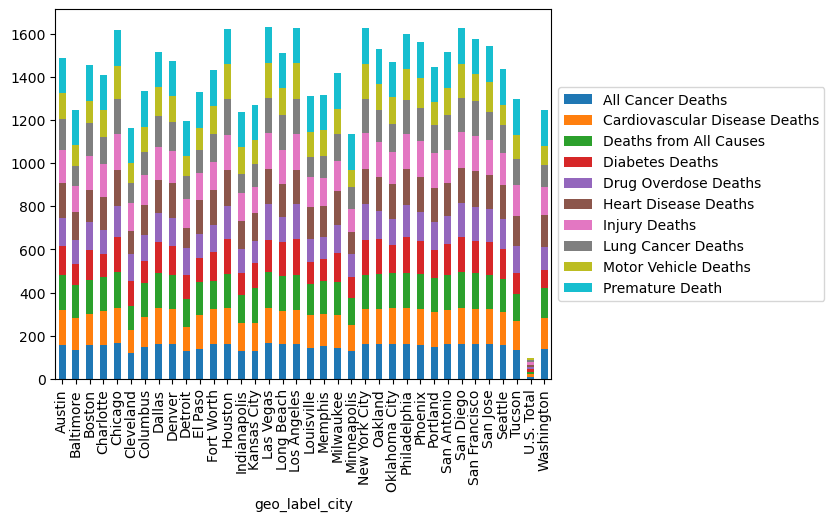

In [197]:
ax = pivot_table.plot(kind='bar', stacked=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



# Data PreProcessing

In [198]:
data.isnull().sum()

metric_item_label                       0
metric_cat_label                        0
metric_subcat_label                     0
metric_item_label_subtitle              0
metric_cat_item_yaxis_label             0
metric_source_desc_label_fn             0
metric_source_desc_label_url_fn         0
geo_label_city                          0
geo_label_state                      1097
geo_label_citystate                     0
geo_fips_code                        1097
value                                 770
date_label                              0
geo_label_proxy_or_real                 0
geo_label_proxy_footnote           133002
geo_fips_desc                           0
date_label_proxy_or_real                0
date_label_proxy_footnote          104164
value_ci_flag_yesno                     0
value_95_ci_low                     54914
value_95_ci_high                    54904
value_90_ci_low                    148292
value_90_ci_high                   148292
geo_strata_region                 

Deleting the columns that contain more than 50% (74'146) missing values.

In [199]:
missing_values = data.isnull().mean()
columns_to_drop = list(missing_values[missing_values > 0.5].index)
data = data.drop(columns_to_drop, axis=1)
columns_to_drop

['geo_label_proxy_footnote',
 'date_label_proxy_footnote',
 'value_90_ci_low',
 'value_90_ci_high',
 'strata_race_sex_label']

Detect Numerical and Categorical Features

In [200]:
num_features = data.select_dtypes(include=['float64', 'int64']).columns
cat_features = data.select_dtypes(include=['object']).columns
num_features, cat_features

(Index(['geo_fips_code', 'value', 'date_label', 'value_95_ci_low',
        'value_95_ci_high'],
       dtype='object'),
 Index(['metric_item_label', 'metric_cat_label', 'metric_subcat_label',
        'metric_item_label_subtitle', 'metric_cat_item_yaxis_label',
        'metric_source_desc_label_fn', 'metric_source_desc_label_url_fn',
        'geo_label_city', 'geo_label_state', 'geo_label_citystate',
        'geo_label_proxy_or_real', 'geo_fips_desc', 'date_label_proxy_or_real',
        'value_ci_flag_yesno', 'geo_strata_region', 'geo_strata_poverty',
        'geo_strata_Population', 'geo_strata_PopDensity',
        'geo_strata_Segregation', 'strata_race_label', 'strata_sex_label'],
       dtype='object'))

Filling in the missing spots thanks to .fillna()

In [201]:
data[cat_features] = data[cat_features].fillna(data[cat_features].mode().iloc[0])
data[num_features] = data[num_features].fillna(data[num_features].mode().iloc[0])


No more missing values. Now is time for data analysis and feature selection

In [202]:
data.describe()

,geo_fips_code,value,date_label,value_95_ci_low,value_95_ci_high
count,1.482920e+05,148292.000000,148292.000000,148292.000000,148292.000000
mean,2.886023e+06,826.066221,2015.227996,299.296110,364.092488
std,1.692824e+06,4293.345997,3.112534,1400.596397,1643.538959
min,4.550000e+05,-1.052184,2010.000000,-148.037039,0.458320
25%,8.200000e+05,10.671715,2013.000000,11.000000,16.000000
50%,2.938000e+06,26.473059,2015.000000,11.000000,16.000000
75%,4.748000e+06,76.710433,2018.000000,36.684472,52.822604
max,5.553000e+06,99408.000000,2020.000000,22650.600880,29193.761110


For value_95_ci_low and value_95_ci_high, the mean has drastically changed. Maybe use another filling type.

Now encode Categorical Features:

In [203]:
one_hot_encoded = pd.get_dummies(data[cat_features], drop_first=True)
data = data.drop(cat_features, axis=1)
data = pd.concat([data, one_hot_encoded], axis=1)

Now for numerical Data

In [204]:
sc = StandardScaler()
scaler = StandardScaler()
data[num_features] = sc.fit_transform(data[num_features])

In [205]:
data

,geo_fips_code,value,date_label,value_95_ci_low,value_95_ci_high,metric_item_label_Adult Mental Distress,metric_item_label_Adult Obesity,metric_item_label_Adult Physical Inactivity,metric_item_label_Adult Smoking,metric_item_label_All Cancer Deaths,...,geo_strata_PopDensity_Lower pop. density (<10k per sq mi),geo_strata_Segregation_Less Segregated (<50%),strata_race_label_American Indian/Alaska Native,strata_race_label_Asian,strata_race_label_Asian/PI,strata_race_label_Black,strata_race_label_Hispanic,strata_race_label_White,strata_sex_label_Female,strata_sex_label_Male
0,1.141869,-0.129081,1.533162,-0.042170,-0.034559,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,1.146595,-0.114622,1.533162,-0.098094,0.161718,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,1
2,1.169043,-0.172517,1.533162,-0.160973,-0.161568,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,1
3,-0.692350,-0.109817,1.533162,0.021199,0.011002,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0.030705,-0.148847,1.533162,-0.138775,-0.028671,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148287,0.451896,1.155315,1.533162,3.833516,3.370699,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
148288,1.575466,1.458509,1.533162,4.397464,4.474153,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
148289,1.151321,0.762411,-1.358382,2.444676,2.501510,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
148290,1.575466,1.136754,-0.394534,3.066605,3.927275,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


# Feature Selection
First try with Lasso regression

In [206]:
X = data.drop('metric_item_label_Adult Mental Distress', axis = 1)
y = data['metric_item_label_Adult Mental Distress']

In [207]:
X_scaled = sc.fit_transform(X)
X_scaled_abs = abs(X_scaled)

In [208]:
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
lasso_coefficiants = lasso.coef_ 

In [209]:
coefs_chi = pd.Series(np.abs(lasso_coefficiants), index=X.columns) 
#Absolute value coefficients
coef_abs = abs(lasso_coefficiants)
top_chi_coefs = coefs_chi.nlargest(15) # Select the 15 features with the highest absolute coefficient values



Text(0.5, 1.0, 'Top 15 Features selected by Lasso regression')

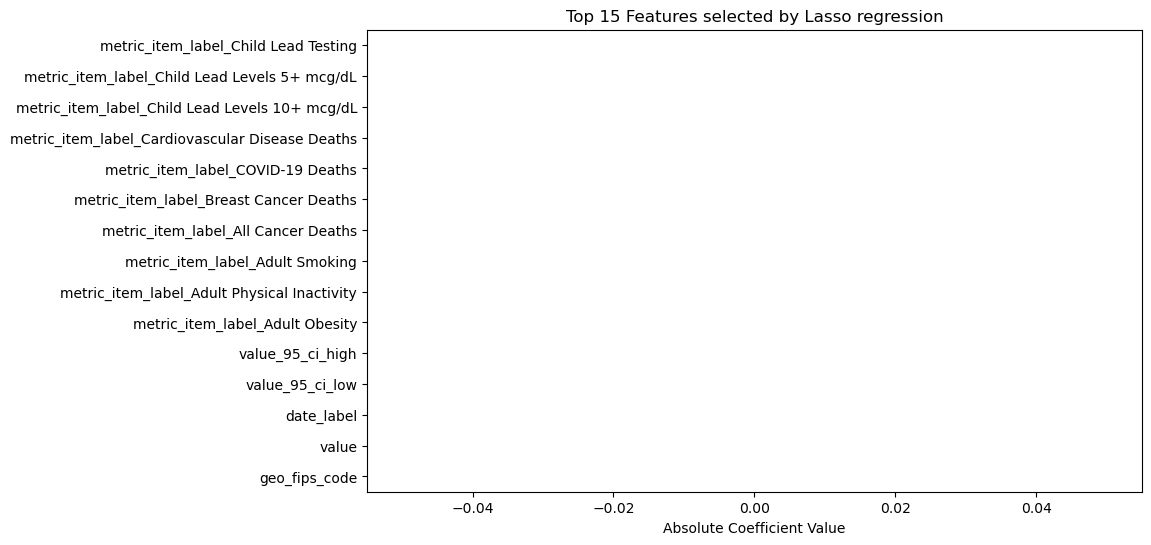

In [210]:
plt.figure(figsize=(10, 6))
top_chi_coefs.plot(kind='barh')
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 15 Features selected by Lasso regression')

Random Forest Method

/var/folders/qt/mgz29q857nl5bsl2gjszg0m40000gn/T/ipykernel_24105/3571419735.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


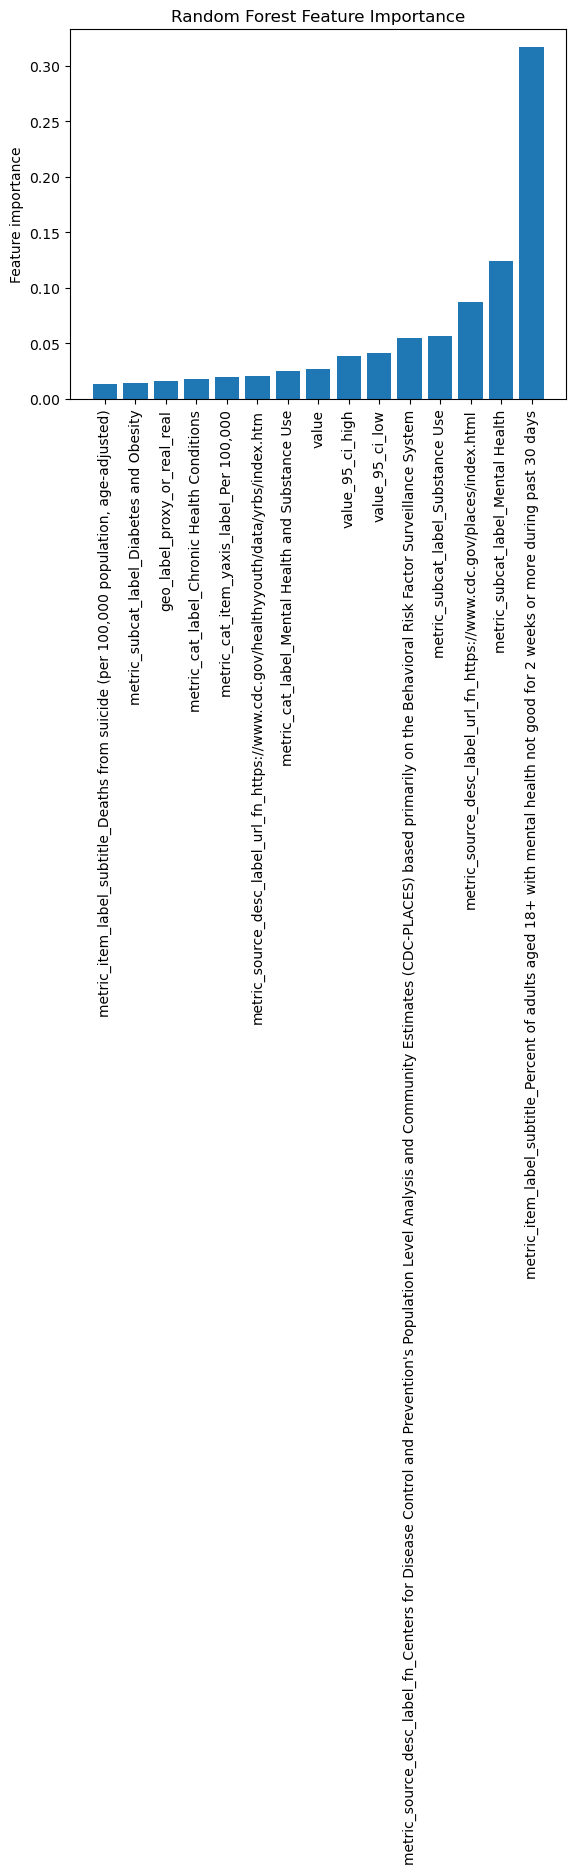

In [211]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

X_scaled = pd.DataFrame(X)

# Get feature importances
importances = rf.feature_importances_

# Get sorted indices of feature importances
sorted_idx = np.argsort(importances)[-15:]

# Get feature names
feature_names = X_scaled.columns[sorted_idx]

# Plot feature importances
plt.bar(range(len(sorted_idx)), importances[sorted_idx][-15:])
plt.xticks(range(len(sorted_idx)), feature_names, rotation=90)
plt.ylabel('Feature importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()